/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: covariance is not positive-semidefinite.


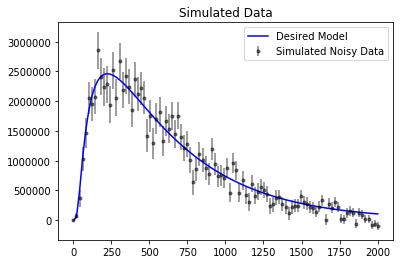

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    parameter_names = ("A", "tau1", "tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*(self.tau1/self.tau2)))
        return self.A*lam*np.exp((-self.tau1/t)-(t/self.tau2))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*(self.tau1/self.tau2)))
        dA = (1./self.A) * self.get_value(t)
        dtau1 = ((1/(self.tau2 * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(self.tau2**2)) - (self.tau1/((self.tau2**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
    
    
    #somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        prob = 1.
        T=2000.
        if not (self.A>0. and self.A<3.5e7) and (self.tau1>0. and self.tau1<T) and (self.tau2>self.tau1 and self.tau2<T):
            return -np.inf
        return np.log(prob)

model = CTSModel_prior(A = paramstrue[2], tau1 = paramstrue[3], tau2 = paramstrue[4])    

#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = model.get_value(x)
yerrscale = 2e2
yerr = np.sqrt(ytrue) * yerrscale
plt.plot(x, ytrue, 'b-', label = "Desired Model")

def simulate(x, yerr, model, A=0.1, c=0.5):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = A*np.exp(-c*(x[:, None] - x[None, :]))
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return y

ysim = simulate(x, yerr, model, A=paramstrue[0], c=paramstrue[1])

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()
plt.show()


Initial log-likelihood: -1338.42801638
Final log-likelihood: -1333.08809452
      fun: 1333.0880945158874
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.90921314e-05,  -1.64384804e-90,  -1.28357113e-05,
         8.17137146e-06,   1.22076104e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 10
   status: 0
  success: True
        x: array([  1.95467663e+00,   2.30258509e+00,   3.20000000e+06,
         1.05243985e+02,   4.76681046e+02])
0.0


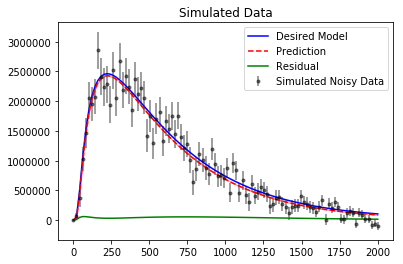

In [2]:
#define a class for our kernel function in celerite
class RealTerm_Prior(ce.terms.RealTerm):

    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not (self.log_a > 0 and self.log_a < np.log(1e6)):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c)


#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(1000), log_c = np.log(10))
gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print soln
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()
print gp.log_prior()

plt.show()


In [3]:
#choosing a startpoint from our optimizer (ignoring kernel terms because the optimizer messes those up for some reason)

paramstart = np.empty(5)
paramstart[2:] = soln.x[2:]
paramstart[:2] = [np.log(100), np.log(10)]
gp.set_parameter_vector(paramstart)

#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not (np.isfinite(gp.log_likelihood(y))):
        return np.inf
    if not (np.isfinite(lp)):
        return -np.inf
    return gp.log_likelihood(y) + lp

gp.compute(x, ysim)

#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/400.))

#step function for mcmc
def MCMCStep(gp, params, y, q, lfunc):
    newparams = q(params)
    r = np.random.rand()
    prob1 = lfunc(params, y, gp)
    prob2 = lfunc(newparams, y, gp)
    if(prob2 == np.inf):
        gp.set_parameter_vector(params)
        return True, newparams
    if((prob2/prob1)>r):
        return False, newparams
    else:
        gp.set_parameter_vector(params)
        return False, params
    
N = int(1e4)
paramset=np.empty([N,5])
paramset[0] = paramstart
bad = False
badparams = []
accept = 0.
print "Running MCMC..."
#running step function many times
for i in range(N-1):
    try:
        bad, paramset[i+1] = MCMCStep(gp, paramset[i], ysim, samplepdf, log_probability)
        if(bad == True):
            bad = False
            badparams.append(paramset[i+1])
            paramset[i+1] = paramset[i]
        if not (paramset[i+1]==paramset[i]).all():
            accept+=1
    except(RuntimeError):
        i-=1
print("Acceptance ratio = {}".format(accept/N))
print("Bad params ratio = {}".format(float(len(badparams))/float(N)))

Running MCMC...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Acceptance ratio = 0.3277
Bad params ratio = 0.0


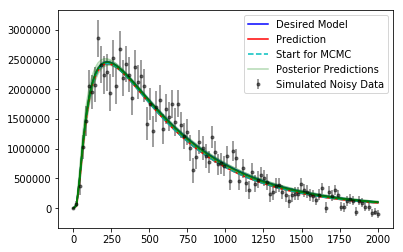

In [4]:
#plotting a sampling of results from MH MCMC along with my previous work

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

model.set_parameter_vector(paramstart[2:])
ystart = model.get_value(x)
plt.plot(x, ystart, 'c--', label = "Start for MCMC")

labeled = False
for i in range(N/1000):
    params = paramset[np.random.randint(len(paramset)),2:]
    model.set_parameter_vector(params)
    
    ymc = model.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)

plt.legend()    
plt.show()

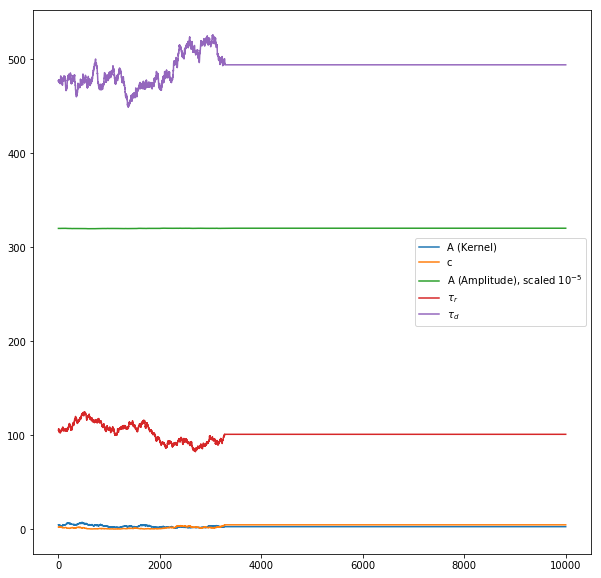

In [5]:
#plotting time series of MCMC

plt.figure(figsize=(10,10))
plt.plot(np.arange(len(paramset)), paramset[:,0], label = "A (Kernel)")
plt.plot(np.arange(len(paramset)), paramset[:,1], label = "c")
plt.plot(np.arange(len(paramset)), paramset[:,2] * 10e-5, label = "A (Amplitude), scaled $10^{-5}$")
plt.plot(np.arange(len(paramset)), paramset[:,3], label = r"$ \tau_r$")
plt.plot(np.arange(len(paramset)), paramset[:,4], label = r"$ \tau_d$")
plt.legend()
plt.show()

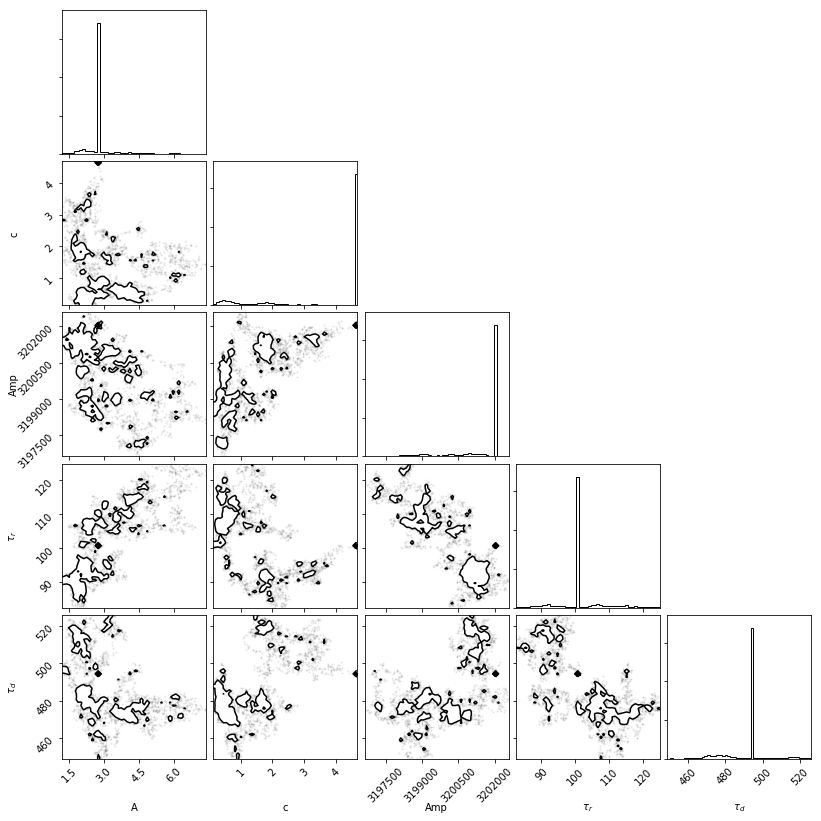

In [ ]:
import corner
names = gp.get_parameter_names()
corner.corner(paramset, bins=50, labels = ["A", "c", "Amp", r"$\tau_r$", r"$\tau_d$"])
plt.show()

In [ ]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee

ndim = 5
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply


In [ ]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
x = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), chain[i,:,j], 'k-', alpha=0.1)
        trueval = paramstrue[j] * np.ones(len(x))
        axarr[j].plot(x, trueval, 'r-')
plt.show()